In [24]:
import os
import re
import numpy as np
import pandas as pd
import itertools as it
from scipy.stats import gmean
from sklearn.decomposition import PCA
#Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
#Local module
import pathway_modules as pathw

## Initial data reading
#### Read the folder files with the mean of $e_{normal}$ and $e_{tumor}$
1. Store names in a list
2. Store values in a list of list to transform later into an array

In [25]:
folder_path = "./data_generated/mean_exp_values/"
file_list = []
data_store = []

for file in os.listdir(folder_path):
    # store the file name withouth path and extention
    file_list.append(file.split('.')[0])
    # store the data from each file
    data_store.append(pd.read_csv(folder_path+'/'+file,
                                  sep='\t',header=None).iloc[:,0])
# numpy array
data_store = np.array(data_store)

### Preparing data

Separating tumor and normal mean values by using numpy mask to evaluate in array and listing tissues and genes

In [26]:
# Creating masks
normal_mask = [name[:6] == 'normal' for name in file_list]
tumor_mask = [name[:5] == 'tumor' for name in file_list]

# List of different tissues
tissues = np.unique(
    [''.join(re.findall('[A-Z]', string)) for string in file_list]
    )
# Ensemble IDs
ensembl_ids = pd.read_csv("./data_generated/ensemble.txt",sep='\t',header=None).iloc[:,0]

Precalculus matrix of differential expression:
$$ Log2 FC = Log2 (e/e_{ref})$$
df $->$ DataFrame with features as columns: ensemble IDs and samples as index: tissues

In [27]:
# Calculate log2 fold-change of gene exprssion with normal tissue as reference
Log2FC = np.log2(data_store[tumor_mask]/data_store[normal_mask])

# DataFrame of gene expression fold-change
df = pd.DataFrame(data=Log2FC,columns=ensembl_ids,index=tissues)

## Pathways
#### Top 28 pathways from Reactome
Read the pathway data and get the expression matrix

In [28]:
top_pathways = pathw.pathway_query(
    "./data_external/data_pathways/Top28_pathways.xls",
    ensembl_ids)
# Non repeated pathway names
top_pathway_names = pd.unique(top_pathways.Pathways)

# Pathway expression matrix
X = pathw.pathway_expression(
    expression_matrix=df,
    pathway_data=top_pathways,
    pathway_names=top_pathway_names)

print(X.shape)

(28, 15)


### Average logarithmic fold-change of genes in top pathways in BRCA
 Graphic

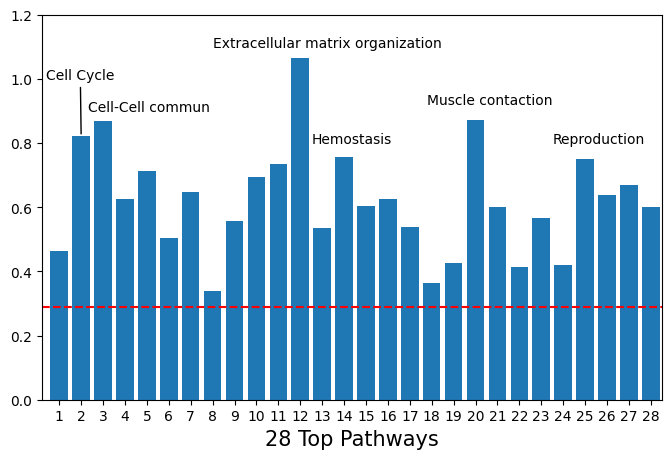

In [29]:
plt.figure(figsize=(8,5))
plt.bar(np.arange(1,29),X.BRCA)
plt.axhline(abs(df.loc['BRCA']).mean(),color='red', 
            linestyle='dashed',linewidth=1.5)

plt.xticks(np.arange(1,29))
plt.xlim(0.2,28.5)
plt.ylim(0,1.2)
plt.xlabel('28 Top Pathways', fontsize=15)

# Annotations
plt.annotate('Cell Cycle',xy=(2,0.82), xytext=(0.4,1),xycoords='data',
             arrowprops=dict(facecolor='black', arrowstyle='-'))
plt.annotate('Cell-Cell commun',xy=(3,0.87), xytext=(2.3,0.9),xycoords='data')
plt.annotate('Extracellular matrix organization',xy=(12,1.06), 
             xytext=(8,1.10),xycoords='data')
plt.annotate('Hemostasis',xy=(14,0.76), xytext=(12.5,0.8),xycoords='data')
plt.annotate('Muscle contaction',xy=(20,0.88), xytext=(17.8,0.92),xycoords='data')
plt.annotate('Reproduction',xy=(25,0.75), xytext=(23.5,0.8),xycoords='data')

# Store the fig
plt.savefig("./figures_tables/Fig 2.pdf", bbox_inches='tight')
# Show the plot
plt.show()

Table II Number of samples and average log-fold change of genes in the 15 tumors studied in the paper

In [30]:
average = abs(df).mean(axis=1)
average.to_csv("./figures_tables/Table II.csv")

### Principal Components Analysis
- Transpose the matrix X first
- And make an uncentered PCA

In [31]:
Y = X.T
# PCA class
pca = PCA(6)
# Tissues as samples and pathways as features
P_matrix = pca.fit(Y)
# Make the mean 0 to uncenter
pca.mean_ = np.zeros(Y.shape)
# PCA transformation matrix
P_matrix = pca.transform(Y)

print(P_matrix.shape)

(15, 6)


### Components
Histogram of components

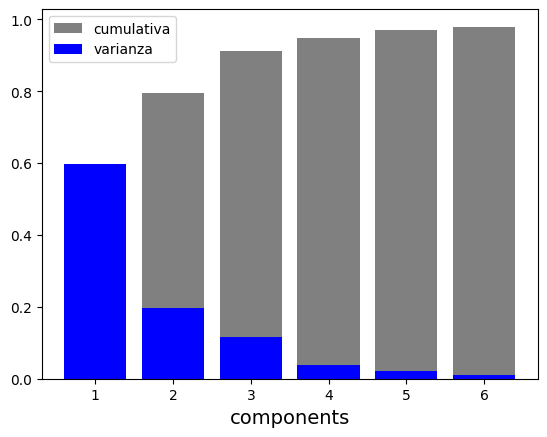

In [32]:
variance = pca.explained_variance_ratio_
label = [r'cumulativa',r'varianza']

plt.bar(np.arange(1,7), variance.cumsum(), color='grey')
plt.bar(np.arange(1,7), variance, color='blue')
plt.xlabel('components', size=14)

plt.legend(label)

Table of components

In [33]:
proyections_table = pd.DataFrame(P_matrix, columns=[f'PC{i}' for i in range(1, 7)])
# Set the index as the tissues type
proyections_table.index = tissues
# Visualization
proyections_table.head(15)

,PC1,PC2,PC3,PC4,PC5,PC6
BLCA,-3.411942,0.028758,-1.069093,0.096427,0.219675,0.170302
BRCA,-3.162593,0.249421,-1.141441,0.137515,0.079870,0.069325
COAD,-3.312517,1.243775,-0.669761,0.121262,0.154084,0.166313
ESCA,-3.900865,0.587321,-0.435974,-0.159395,-0.041864,0.005436
HNSC,-2.999088,0.245472,-1.005277,0.033404,-0.081237,0.327071
KIRC,-2.947321,1.016104,-1.229499,0.343436,-0.083474,0.024773
KIRP,-2.839228,1.064312,-1.246433,0.291792,-0.018856,0.053774
LIHC,-3.781271,0.250012,-0.292646,0.669907,0.064483,0.162717
LUAD,-3.260696,0.418493,-0.922998,0.186078,0.027538,0.082858
LUSC,-4.535661,0.565234,-1.174010,0.166588,-0.129797,0.128526


### Weights
Stored in csv files

In [34]:
# DataFrame for all components weights
for i in range(2):
    # Create the table
    pci = pd.DataFrame({f'PC{i+1}': pca.components_[i,:], 'Pathways': top_pathway_names})
    # Sort descending
    pci.sort_values(f'PC{i+1}',ascending=False)
    # Store it
    pci.to_csv(f'./data_generated/weights_PC{i+1}.csv')

Scatterplot of the first two components

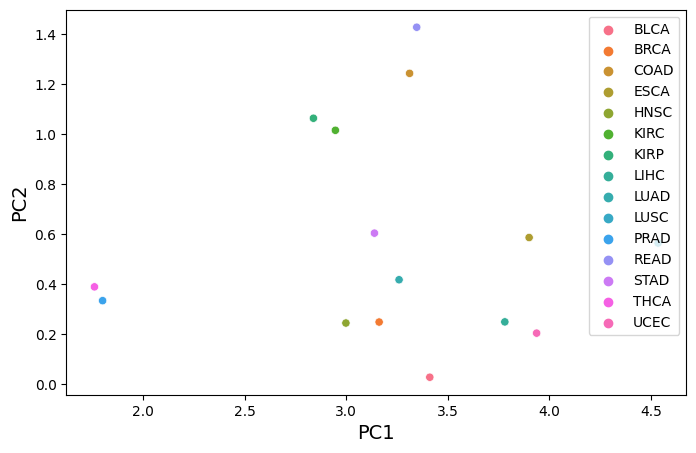

In [42]:
plt.figure(figsize = (8,5))
plt.xlabel('PC1', size=14)
plt.ylabel('PC2', size=14)

sns.scatterplot( x = -P_matrix[:,0], y = P_matrix[:,1], hue=X.columns)
plt.show()

Separate the group of points and create array of labels

In [36]:
# will be use as labels
hue = np.array(15*['Cluster 2'])

# Use numpy logical indexing to set elements in 'hue' based on conditions
hue[-P_matrix[:, 0] < 2.5] = 'Cluster 1'
hue[P_matrix[:, 1] > 0.8] = 'Cluster 3'

### Descriptive scatterplot

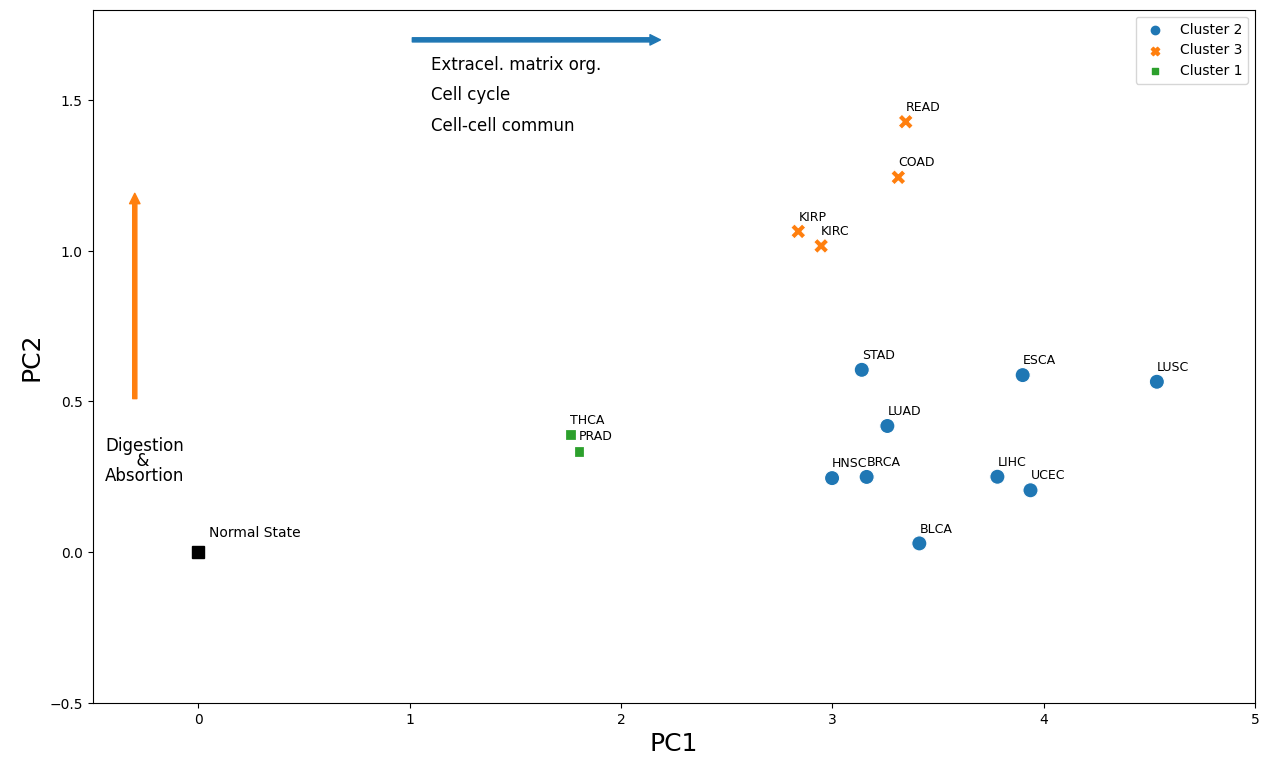

In [37]:
# Set figure dimension
fig = plt.figure(figsize = (15,9),facecolor='w')

# get current axe
ax = plt.gca()

# The axes labels
plt.xlabel('PC1', fontsize=18)
plt.ylabel('PC2', size=18)
# xy limits
plt.xlim(-0.5,5)
plt.ylim(-0.5,1.8)

# Scatterplot 
sns.scatterplot( x = -P_matrix[:,0], y = P_matrix[:,1], hue=hue, s=120, 
                 style=hue)
# Normal state point
plt.plot(0, 0, 's', color='k',markersize=8, markeredgecolor ='black')
plt.annotate('Normal State',xy=(0.05,0.05), xycoords='data',fontsize=10)

# Horizontal arrow
harrow = mpatches.FancyArrowPatch((1, 1.7), (2.2, 1.7),
                                 mutation_scale=15, color="C0")
# Horizontal arrow annotations
ax.annotate('Extracel. matrix org.',
            xy=(1.1,1.6), xycoords='data',fontsize=12)
ax.annotate('Cell cycle',
            xy=(1.1, 1.5), xycoords='data',fontsize=12)
ax.annotate('Cell-cell commun',
            xy=(1.1,1.4), xycoords='data',fontsize=12)
ax.add_patch(harrow)
# Vertical arrow
varrow = mpatches.FancyArrowPatch((-0.3, 0.5), (-0.3, 1.2),
                                 mutation_scale=15, color="C1")
# Vertical annotations
ax.annotate('Digestion',
            xy=(105, 315), xycoords='figure pixels',fontsize=12)
ax.annotate('      &',
            xy=(105, 300), xycoords='figure pixels',fontsize=12)
ax.annotate('Absortion',
            xy=(105, 285), xycoords='figure pixels',fontsize=12)
ax.add_patch(varrow)

# Add the labels to the points
for i in range(len(tissues)):
    plt.annotate(tissues[i], (-P_matrix[:,0][i], P_matrix[:,1][i]), 
                 textcoords='offset points', xytext=(0, 8),fontsize=9)

# Store the fig
fig.savefig("./figures_tables/Fig 1.pdf", bbox_inches='tight')
# Show the plot
plt.show()

In [38]:
comb_genes = np.zeros([28,28])
p = pd.DataFrame(data=top_pathway_names)

for ensbl in pd.unique(top_pathways.Ensemble):
    top_pathways[top_pathways.Ensemble == ensbl]


In [39]:
p==[top_pathways[top_pathways.Ensemble == 'ENSG00000005893'].Pathways]

ValueError: Unable to coerce list of <class 'pandas.core.series.Series'> to Series/DataFrame

In [ ]:
pd.unique(pathways[0]).shape

(10785,)

In [ ]:
p = pd.DataFrame(data=['P'+str(i) for i in range(1,29)] ,index=top_pathway_names, columns=['Pathway_id'])
#['P'+str(i) for i in range(1,29)]

In [ ]:
pathways[pathways[0] == 'ENSG00000005893'][1]

ValueError: ('Lengths must match to compare', (3,), (28,))

In [ ]:
for i in it.permutations([0,7422,8167],2):
    print(i)

(0, 7422)
(0, 8167)
(7422, 0)
(7422, 8167)
(8167, 0)
(8167, 7422)


In [ ]:
it?

Type:        module
String form: <module 'itertools' (built-in)>
Docstring:  
Functional tools for creating and using iterators.

Infinite iterators:
count(start=0, step=1) --> start, start+step, start+2*step, ...
cycle(p) --> p0, p1, ... plast, p0, p1, ...
repeat(elem [,n]) --> elem, elem, elem, ... endlessly or up to n times

Iterators terminating on the shortest input sequence:
accumulate(p[, func]) --> p0, p0+p1, p0+p1+p2
chain(p, q, ...) --> p0, p1, ... plast, q0, q1, ...
chain.from_iterable([p, q, ...]) --> p0, p1, ... plast, q0, q1, ...
compress(data, selectors) --> (d[0] if s[0]), (d[1] if s[1]), ...
dropwhile(pred, seq) --> seq[n], seq[n+1], starting when pred fails
groupby(iterable[, keyfunc]) --> sub-iterators grouped by value of keyfunc(v)
filterfalse(pred, seq) --> elements of seq where pred(elem) is False
islice(seq, [start,] stop [, step]) --> elements from
       seq[start:stop:step]
starmap(fun, seq) --> fun(*seq[0]), fun(*seq[1]), ...
tee(it, n=2) --> (it1, it2 , ... 